# CPSC 540 Assignment: Getting to Know Graph Neural Networks

## Instructions
This assignment consists of two parts. In Part I, you implement a Graph Neural Network (GNN)
to classify MNIST digits using the PyTorch Geometric Package. In Part II, you answer a few short
questions regarding GNNs and their strengths and shortcomings.

You will need the code provided in dataset.py and models.py. You must also download MNIST's dataset from: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv?resource=download


## Part I

In this part of the assignment, we reformulate the MNIST digit classification problem into a graph
classification problem and learn to create a custom GNN using the Pytorch Geometric package (PyG). Please note that you are only required to put your code in sections that say "Your Code Goes Here".

### Import required packages
Please Make sure that torch and torch_geometric packages are installed as per:
https://pytorch.org/ and https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html

Other required packages are sklearn, numpy, pandas, networkx and matplotlib.

In [2]:
from torch_geometric.loader import DataLoader
from torch.utils.data import WeightedRandomSampler
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.nn as nn
from models import CNN, GCNClassifier
from torch_geometric.nn import MessagePassing
from sklearn.metrics import accuracy_score
import numpy as np
import time
from dataset import MNISTPixelGraphDataset
from torch_geometric.nn import Sequential, global_add_pool


### MNIST Dataset as Graphs
Study the code in class "MNISTPixelGraphDataset" in dataset.py and use it to plot one sample from the dataset as a graph.
In your plot, the colour for each node must be associated with its pixel value. (You can use the test or the training set)

HINT1: Use the nx_graph attribute of the sample and nx_draw to draw the graph structure. You can find the pixel values
in the image attribute of the sample.

HINT2: To put the nodes in a grid position, use these instructions:
https://stackoverflow.com/questions/35109590/how-to-graph-nodes-on-a-grid-in-networkx

If you're interested in how a dataset is created for PyG, you can read more here:
https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html

In [3]:
# Create the dataset
dataset = MNISTPixelGraphDataset(path_to_dataset="./mnist", train=True)

# Fetch a sample
first_sample = dataset[100]

# Your Code Goes Here

Solution:

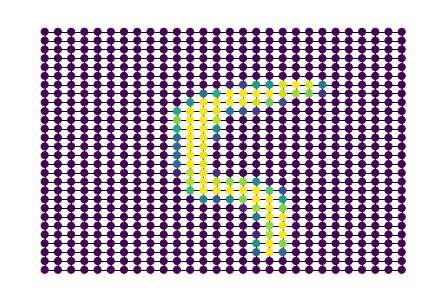

In [4]:
# Get image and flatten it
node_values = torch.flatten(first_sample.image.squeeze())
nx_graph = first_sample.nx_graph

# Visualize the graph
nx.draw(nx_graph, pos={(x, y): (y, -x) for x, y in nx_graph.nodes()}, node_size=50, node_color=node_values)
plt.show()

### Graph Classification

From the example sample that you drew, you can see that each MNIST digit is transformed into a grid graph where each
node corresponds to a pixel in the image. Therefore, we have reformulated the problem from image classification to graph
classification. As we saw in the lecture, for graph-level prediction tasks, GNN layers are followed by a READOUT layer to obtain an embedding for the whole graph before any downstream tasks.

Before creating the models, Let's create the dataloaders from a subset of the datasets to save time:

In [5]:
# Create the training and test dataset
train_dataset = MNISTPixelGraphDataset(path_to_dataset="./mnist", train=True)
test_dataset = MNISTPixelGraphDataset(path_to_dataset="./mnist", train=True)

print("The training set has {} samples.".format(len(train_dataset)))
print("The test set has {} samples.".format(len(test_dataset)))

# create the dataloaders (only use a subset of the dataset)
num_samples = 1000
train_sampler = WeightedRandomSampler(weights=train_dataset.class_weights, num_samples=num_samples, 
                                      replacement=False)
test_sampler = WeightedRandomSampler(weights=test_dataset.class_weights, num_samples=num_samples, 
                                     replacement=False)
trainloader = DataLoader(train_dataset, batch_size=10, drop_last=True, sampler=train_sampler)
testloader = DataLoader(test_dataset, batch_size=10, drop_last=True, sampler=test_sampler)

The training set has 60000 samples.
The test set has 60000 samples.


Since a single pixel value as node features is not suitable, we use a CNN to increase the channel depth of each pixel.
Study the code for GCNClassifier and CNN in models.py and create one CNN and one GCN model with your desired hyper-parameters.

Important: In GCNClassifier, notice how a readout layer is used prior to the output MLP network.

In [6]:
# Your Code Goes Here

Solution:

In [7]:
# Create the models
cnn_embedder = CNN(out_channels=[16, 32, 64, 128],
                   kernel_sizes=[3, 3, 3, 3],
                   pool_sizes=[1, 1, 1, 1],
                   cnn_dropout_p=0.0)

gnn_classifiers = GCNClassifier(input_feature_dim=128,
                                dropout_p=0.0,
                                gnn_hidden_dims=[64, 32, 16],
                                mlp_hidden_dim=16,
                                num_classes=10)

The following snippet includes the training and testing loops. Run it and report the achieved accuracy on the test set
after 10 epochs


In [7]:
# Create the loss function and the optimizer
optimizer = Adam(list(cnn_embedder.parameters()) + list(gnn_classifiers.parameters()))
loss_func = nn.CrossEntropyLoss()

# Training iterations
for epoch in range(10):

    total_loss = 0

    train_time = time.time()
    for i, data_batch in enumerate(trainloader):

        optimizer.zero_grad()

        # Create node embeddings using the CNN
        h = cnn_embedder(data_batch.image).permute(0, 2, 3, 1)
        h = torch.reshape(h, [h.shape[0]*h.shape[1]*h.shape[2], -1])
        data_batch.x = h

        # Use GNN layers to propagate messages between pixel embeddings
        x = gnn_classifiers(data_batch)

        loss = loss_func(x, data_batch.y)

        loss.backward()
        optimizer.step()

        total_loss += loss.detach().cpu().item()

        # Save label and prediction
        labels = np.concatenate((labels, data_batch.y.detach().cpu().numpy()), axis=0) if i != 0 else \
        data_batch.y.detach().cpu().numpy()
        prediction = np.argmax(x.detach().cpu().numpy(), axis=1)
        predictions = np.concatenate((predictions, prediction), axis=0) if i != 0 else prediction

    train_time = time.time() - train_time

    print("The training epoch loss is {}.".format(total_loss))
    print("The training accuracy is {}.".format(accuracy_score(labels, predictions)))
    print("The training epoch took {} seconds.".format(train_time))

    total_loss = 0

    test_time = time.time()
    for i, data_batch in enumerate(testloader):

        # Create node embeddings using the CNN
        h = cnn_embedder(data_batch.image).permute(0, 2, 3, 1)
        h = torch.reshape(h, [h.shape[0]*h.shape[1]*h.shape[2], -1])
        data_batch.x = h

        # Use GNN layers to propagate messages between pixel embeddings
        x = gnn_classifiers(data_batch)

        loss = loss_func(x, data_batch.y)

        total_loss += loss.detach().cpu().item()

        # Save label and prediction
        labels = np.concatenate((labels, data_batch.y.detach().cpu().numpy()), axis=0) if i != 0 else \
        data_batch.y.detach().cpu().numpy()
        prediction = np.argmax(x.detach().cpu().numpy(), axis=1)
        predictions = np.concatenate((predictions, prediction), axis=0) if i != 0 else prediction

    test_time = time.time() - test_time

    print("The test epoch loss is {}.".format(total_loss))
    print("The test accuracy is {}.".format(accuracy_score(labels, predictions)))
    print("The test epoch took {} seconds.".format(test_time))

The training epoch loss is 210.56462037563324.
The training accuracy is 0.247.
The training epoch took 38.701998233795166 seconds.
The test epoch loss is 195.65899002552032.
The test accuracy is 0.359.
The test epoch took 31.576747179031372 seconds.
The training epoch loss is 186.04701805114746.
The training accuracy is 0.415.
The training epoch took 38.10100054740906 seconds.
The test epoch loss is 173.3077290058136.
The test accuracy is 0.47.
The test epoch took 33.509108781814575 seconds.
The training epoch loss is 164.56189095973969.
The training accuracy is 0.517.
The training epoch took 41.82200026512146 seconds.
The test epoch loss is 150.90171253681183.
The test accuracy is 0.568.
The test epoch took 32.02603626251221 seconds.
The training epoch loss is 137.7804740667343.
The training accuracy is 0.645.
The training epoch took 36.77999949455261 seconds.
The test epoch loss is 128.47251737117767.
The test accuracy is 0.681.
The test epoch took 30.971415758132935 seconds.
The tra

Solution:
A test accuracy of 85.9% is achieved.

### Implementing Graph Isomorphism Network
In this part of the assignment, we will be using PyG to implement Graph Isomorphism Network (GIN). First, read the paper
found at:
https://arxiv.org/pdf/1810.00826.pdf

Also, read the documentation for PyG custom MessagePassing modules here:
https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

In the following cell complete the implementation for GIN. Here, you will be implementing the model characterized by
equation 4.1 in the paper above.

In [ ]:
class GIN(MessagePassing):
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 epsilon=0):

        super().__init__(aggr='sum')

        # Your Code Goes Here

    def forward(self, x, edge_index):

        return self.propagate(edge_index, x=x)

    def update(self, aggregated_messages, x):

        # Your Code Goes Here

        return h


Solution:

In [8]:
class GIN(MessagePassing):
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 epsilon=0):

        super().__init__(aggr='sum')

        self.update_mlp = nn.Sequential(nn.Linear(in_features=input_dim,
                                                  out_features=hidden_dim),
                                        nn.LayerNorm(hidden_dim),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(in_features=hidden_dim,
                                                  out_features=hidden_dim),
                                        nn.LayerNorm(hidden_dim),
                                        nn.ReLU(inplace=True))

        self.eps = epsilon

    def forward(self, x, edge_index):

        return self.propagate(edge_index, x=x)

    def update(self, aggregated_messages, x):

        return self.update_mlp((1 + self.eps) * x + aggregated_messages)

Now that you've implemented a GIN layer, we can construct a similar classifier as GCNClassifier that uses GIN instead.
Complete the code below to implement that.

HINT: Pay close attention to how READOUT is implemented for GIN as found in equation 4.2 in the paper.

In [ ]:
class GINClassifier(nn.Module):
    def __init__(self,
                 input_feature_dim,
                 dropout_p,
                 gnn_hidden_dims,
                 mlp_hidden_dim,
                 num_classes):
        super().__init__()

        # Your Code Goes Here

    def forward(self, g):

        # Your Code Goes Here

        return h

Solution:

In [11]:
class GINClassifier(nn.Module):
    def __init__(self,
                 input_feature_dim,
                 dropout_p,
                 gnn_hidden_dims,
                 mlp_hidden_dim,
                 num_classes):
        super().__init__()

        self.layers = nn.ModuleList()

        mlp_input_dim = sum(gnn_hidden_dims)+input_feature_dim

        # GNN layers
        for gnn_hidden_dim in gnn_hidden_dims:
            self.layers.append(Sequential('x, edge_index', [(GIN(input_dim=input_feature_dim,
                                                                 hidden_dim=gnn_hidden_dim), 
                                                             'x, edge_index -> x'),
                                                            nn.BatchNorm1d(gnn_hidden_dim),
                                                            nn.Dropout(p=dropout_p),
                                                            nn.ReLU(inplace=True)]))
            input_feature_dim = gnn_hidden_dim

        # Output MLP layers
        self.output_mlp = nn.Sequential(nn.Linear(in_features=mlp_input_dim,
                                                  out_features=mlp_hidden_dim),
                                        nn.BatchNorm1d(mlp_hidden_dim),
                                        nn.Dropout(p=dropout_p),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(in_features=mlp_hidden_dim,
                                                  out_features=num_classes))

    def forward(self, g):

        h = g.x
        edge_index = g.edge_index

        jk_list = [h]

        # GNN layers
        for gnn_layer in self.layers:
            h = gnn_layer(h, edge_index)
            jk_list.append(h)

        for i, h in enumerate(jk_list):
            readout_h = torch.concat((readout_h, global_add_pool(h, g.batch)), dim=1) if i != 0 else \
            global_add_pool(h, g.batch)

        # Output MLP
        h = self.output_mlp(readout_h)

        return h

Run the following training and testing iterations and compare the results with GCNClassifier:

In [12]:
# Create the models
cnn_embedder = CNN(out_channels=[16, 32, 64, 128],
                   kernel_sizes=[3, 3, 3, 3],
                   pool_sizes=[1, 1, 1, 1],
                   cnn_dropout_p=0.0)

gnn_classifiers = GINClassifier(input_feature_dim=128,
                                dropout_p=0.0,
                                gnn_hidden_dims=[64, 32, 16],
                                mlp_hidden_dim=16,
                                num_classes=10)

# Create the loss function and the optimizer
optimizer = Adam(list(cnn_embedder.parameters()) + list(gnn_classifiers.parameters()))
loss_func = nn.CrossEntropyLoss()

# Training iterations
for epoch in range(10):

    total_loss = 0

    train_time = time.time()
    for i, data_batch in enumerate(trainloader):

        optimizer.zero_grad()

        # Create node embeddings using the CNN
        h = cnn_embedder(data_batch.image).permute(0, 2, 3, 1)
        h = torch.reshape(h, [h.shape[0]*h.shape[1]*h.shape[2], -1])
        data_batch.x = h

        # Use GNN layers to propagate messages between pixel embeddings
        x = gnn_classifiers(data_batch)

        loss = loss_func(x, data_batch.y)

        loss.backward()
        optimizer.step()

        total_loss += loss.detach().cpu().item()

        # Save label and prediction
        labels = np.concatenate((labels, data_batch.y.detach().cpu().numpy()), axis=0) if i != 0 else \
        data_batch.y.detach().cpu().numpy()
        prediction = np.argmax(x.detach().cpu().numpy(), axis=1)
        predictions = np.concatenate((predictions, prediction), axis=0) if i != 0 else prediction

    train_time = time.time() - train_time

    print("The training epoch loss is {}.".format(total_loss))
    print("The training accuracy is {}.".format(accuracy_score(labels, predictions)))
    print("The training epoch took {} seconds.".format(train_time))

    total_loss = 0

    test_time = time.time()
    for i, data_batch in enumerate(testloader):

        # Create node embeddings using the CNN
        h = cnn_embedder(data_batch.image).permute(0, 2, 3, 1)
        h = torch.reshape(h, [h.shape[0]*h.shape[1]*h.shape[2], -1])
        data_batch.x = h

        # Use GNN layers to propagate messages between pixel embeddings
        x = gnn_classifiers(data_batch)

        loss = loss_func(x, data_batch.y)

        total_loss += loss.detach().cpu().item()

        # Save label and prediction
        labels = np.concatenate((labels, data_batch.y.detach().cpu().numpy()), axis=0) if i != 0 else \
        data_batch.y.detach().cpu().numpy()
        prediction = np.argmax(x.detach().cpu().numpy(), axis=1)
        predictions = np.concatenate((predictions, prediction), axis=0) if i != 0 else prediction

    test_time = time.time() - test_time

    print("The test epoch loss is {}.".format(total_loss))
    print("The test accuracy is {}.".format(accuracy_score(labels, predictions)))
    print("The test epoch took {} seconds.".format(test_time))

The training epoch loss is 217.88629686832428.
The training accuracy is 0.188.
The training epoch took 39.37914991378784 seconds.
The test epoch loss is 210.4332228899002.
The test accuracy is 0.227.
The test epoch took 30.758558750152588 seconds.
The training epoch loss is 199.6740380525589.
The training accuracy is 0.312.
The training epoch took 45.289238691329956 seconds.
The test epoch loss is 185.48757994174957.
The test accuracy is 0.392.
The test epoch took 33.70492339134216 seconds.
The training epoch loss is 169.54484951496124.
The training accuracy is 0.478.
The training epoch took 39.958492040634155 seconds.
The test epoch loss is 152.61178994178772.
The test accuracy is 0.617.
The test epoch took 33.67289471626282 seconds.
The training epoch loss is 137.02280163764954.
The training accuracy is 0.677.
The training epoch took 41.22500729560852 seconds.
The test epoch loss is 126.97516375780106.
The test accuracy is 0.696.
The test epoch took 33.87322735786438 seconds.
The tra

Solution:

We see that the GIN classifier beats the GCN classifier by around 2% when 10 training epochs are used. This could be due
to the better representative power of GINs and their ability to match WL-test's performance in distinguishing graphs.

## Part II
In this part, you must provide short answers to questions on GNNs, their implementation, strengths and shortcomings.

1. Why can GNNs perform training and inference on graphs of different sizes (different number of nodes)?

Solution: GNNs rely on message passing operations between nodes during training and inference, and these operations are carried out in a local manner.
This means that each node only gathers information from its immediate neighbourhood based on local connectivity, which does not rely on the overall graph size.

2. What are the properties of the Graph Isomorphism Network (GIN) that makes it as expressive as the WL test?

Solution: GIN achieves the similar performance as the Wesfeiler-Lehman (WL) test by using message and update and readout functions that are injective, meaning that different multi-sets are mapped to different embeddings.

3. What are the different components of the message passiong operations used in GNNs. What are their purpose.

Solution: message function: creates incoming messages from neighbours using both source and destination embeddings. aggregate function: a permutation-invariant function aggregating messages from the neighbours. update function: updates the destination node embedding using the aggregated messages and the node's previous embedding. 

4. What are the two setting where GNNs are used. What are their applications?

Solution: GNNs can be used in discriminative and generative settting. Discriminative GNNs can perform different node/edge/graph predictions tasks such as predicting properties of a molecular structure. Generative GNNs are used to generate graphs which can be used to study properties of graphs and their asymptotic behaviour.

5. What is the graphical interpretation of increasing GNN layers? What are the complications of increasing GNN layers?

Solution: K GNN layers corresponds to performing message passing in the K-hop neighbourhood of each node. Increasing GNN layers beyond a certain threshold has been shown to degrade performance due to Laplacian over-smoothing and over-squashing.
